In [17]:
# Attempting to recover training data using model's parameters and a DCGAN that was trained on similar data
# Author: Suraj Neupane
# Written from scratch as a part of a Research Project 2025, Concordia University of Edmonton.
import numpy as np

import torch
from torch import nn
from torch.nn import functional

from torch.utils import data
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
torch.__version__

'2.7.1+cu118'

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
device

'cpu'

In [21]:
# DCGAN Implementation Class
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_channels, features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # Input shape: img_channels x 64 x 64
            nn.Conv2d(
              in_channels=img_channels, out_channels=features_d, kernel_size=4, stride=2, padding=1
            ), # Output shape: features_d x 32 x 32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1), # Output shape: features_d*2 x 16 x 16
            self._block(features_d*2, features_d*4, 4, 2, 1), # Output shape: features_d*4 x 8 x 8
            self._block(features_d*4, features_d*8, 4, 2, 1), # Output shape: features_d*8 x 4 x 4
           
            nn.Conv2d(in_channels=features_d*8, out_channels=1, kernel_size=4, stride=2, padding=0), # Output shape: 1 x 1
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, X):
        return self.disc(X)


In [22]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, features_g):
        super().__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g*16, 4, 1, 0), # z_dim: (batch_size, 100, 1, 1) -> (batch_size, 1024, 4, 4)
            self._block(features_g*16, features_g*8, 4, 2, 1), # z_dim: (batch_size, 1024, 4, 4) -> (batch_size, 512, 8, 8)
            self._block(features_g*8, features_g*4, 4, 2, 1), # z_dim: (batch_size, 512, 8, 8) -> (batch_size, 256, 16, 16)
            self._block(features_g*4, features_g*2, 4, 2, 1), # z_dim: (batch_size, 128, 16, 16) -> (batch_size, 64, 32, 32)
            nn.ConvTranspose2d(
                in_channels=features_g*2, out_channels=img_channels, kernel_size=4, stride=2, padding=1 # z_dim: (batch_size, 64, 32, 32) -> (batch_size, 1, 64, 64)
            ),
            nn.Tanh(),
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size, stride, padding, bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.ReLU(),
        )

    def forward(self, X):
        return self.gen(X)

In [23]:
# Hyperparams
z_dim = 100
img_channels = 1
features_disc = 64
features_gen = 64

In [24]:
# Create the model instances
gen = Generator(z_dim, img_channels, features_gen).to(device)
disc = Discriminator(img_channels, features_disc).to(device)

In [25]:
# Load the trained GAN
gen.load_state_dict(torch.load('saved models/Generator2.pth', weights_only=True, map_location=torch.device('cpu')))
disc.load_state_dict(torch.load('saved models/Discriminator2.pth', weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [26]:
# Generate a random fake image
noise = torch.randn(1, z_dim, 1, 1).to(device)
fake_img = gen(noise)

In [27]:
fake_img.shape

torch.Size([1, 1, 64, 64])

torch.Size([64, 64])


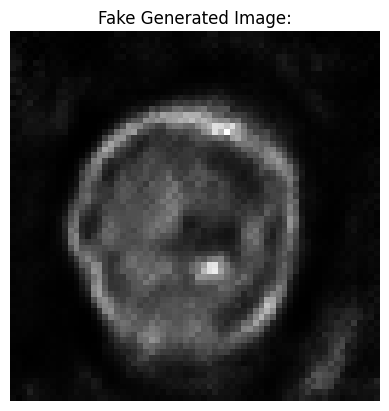

In [28]:
fake_img = fake_img.squeeze()
print(fake_img.shape)
plt.axis(False)
plt.title('Fake Generated Image:')
plt.imshow(fake_img.cpu().detach(), cmap='gray')

In [29]:
# Target Model
class TFCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            Reshape(),
        )

        self.h_size = 64 * 4 * 4

        self.classifier = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(True),
            nn.Linear(128, n_classes)
        )

    def forward(self, xs):
        code = self.encoder(xs)
        logits = self.classifier(code)
        return code, logits


In [30]:
class Reshape(nn.Module):
    def __init__(self,):
        super().__init__()

    def forward(self, xs):
        return xs.reshape((xs.shape[0], -1))

In [31]:
class ClassifyNet(nn.Module):
    def __init__(self, net, init_way, n_classes, input_size=None):
        super().__init__()
        self.net = net
        self.init_way = init_way
        self.n_classes = n_classes

        model = TFCNN(n_classes)

        self.h_size = model.h_size

        # Convo and pool layers
        self.encoder = model.encoder

        # Classifier layer
        self.classifier = nn.Linear(
            self.h_size, self.n_classes, bias=False
        )

        if self.init_way == "orth":
            ws = get_orth_weights(self.h_size, self.n_classes)
            self.classifier.load_state_dict({"weight": ws})

    def forward(self, xs):
        hs = self.encoder(xs)
        logits = self.classifier(hs)
        return hs, logits

In [32]:
def load_target_model(base_net, n_classes, path):
    # Create the base model
    model = ClassifyNet(net=base_net, init_way='none', n_classes=n_classes)
    # Load the model
    model.load_state_dict(torch.load(path, weights_only=True))

    return model

In [37]:
# Target Models Loading
BASE_NET = 'TFCNN'
DATASET = 'tumor4'
N_CLASSES = 4

fedavg_model = load_target_model(base_net=BASE_NET, n_classes=N_CLASSES, path='saved models/fedavg_global_model.pth').to(device)
feddyn_model = load_target_model(base_net=BASE_NET, n_classes=N_CLASSES, path='saved models/feddyn_global_model.path').to(device)
fedopt_model = load_target_model(base_net=BASE_NET, n_classes=N_CLASSES, path='saved models/fedopt_global_model.path').to(device)
moon_model = load_target_model(base_net=BASE_NET, n_classes=N_CLASSES, path='saved models/moon_global_model.path').to(device)
print('Models loaded successfully!')

# Put all the models in evaluation mode
fedavg_model.eval()
feddyn_model.eval()
fedopt_model.eval()
moon_model.eval()

Models loaded successfully!


ClassifyNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Reshape()
  )
  (classifier): Linear(in_features=1024, out_features=4, bias=False)
)

In [90]:
# Generate 80 fake images from the DCGAN
torch.manual_seed(42)
image_count = 80
latent_vectors = torch.randn(image_count, z_dim, 1, 1).to(device)
print(latent_vectors.shape)

torch.Size([80, 100, 1, 1])


In [97]:
# Display one of the random image
img = gen(latent_vectors[56].to(device)).squeeze(dim=0).squeeze(dim=0)
print(img.shape)

torch.Size([64, 64])


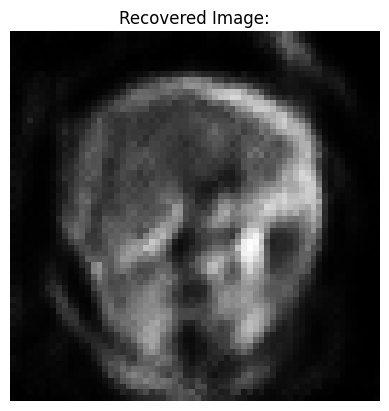

In [98]:
plt.axis(False)
plt.title('Recovered Image:')
plt.imshow(img.cpu().detach(), cmap='gray')

In [99]:
img = img.unsqueeze(dim=0).unsqueeze(dim=0) # Add the two extra dimensions to make it (batch_size, channels, h, w)
print(img.shape)
img = img.repeat(1, 3, 1, 1) # Increase the color channels from 1 to 3 by repeating the color channel
img = functional.interpolate(img, size=(32, 32), mode='nearest') # Change the image shape from 64x64(DCGAN output) to 32x32(Model input)
        
hs, logits = fedavg_model(img)

torch.Size([1, 1, 64, 64])


In [103]:
logits.shape

torch.Size([1, 4])

In [116]:
# Send all the 80 images in batch
random_images = gen(latent_vectors.to(device)).squeeze(dim=0).squeeze(dim=0)
print(random_images.shape)

torch.Size([80, 1, 64, 64])


In [117]:
random_images = random_images.repeat(1, 3, 1, 1)
print(random_images.shape)

torch.Size([80, 3, 64, 64])


In [118]:
random_images_resized = functional.interpolate(random_images, size=(32, 32), mode='nearest')
random_images_resized.shape

torch.Size([80, 3, 32, 32])

In [162]:
def filter_images(model, images, target_class, prob_threshold):
    hs, logits = fedavg_model(images) # Send the images down the model and get the prediction logits
    probs = functional.softmax(logits, dim=1) # Convert the logits into probabilities
    mask = probs[:, target_class] > prob_threshold
    filtered_images = images[mask]

    return filtered_images, probs[mask][:, target_class] # Return the image and the corresponding probabilities

In [167]:
# Test
result, prob = filter_images(fedavg_model, random_images_resized, 0, 0.8)
result.shape, prob.shape

(torch.Size([7, 3, 32, 32]), torch.Size([7]))

In [168]:
prob_threshold = 0.8

In [183]:
# Fedavg
class0_filtered_fedavg, fedavg_class0_probs = filter_images(fedavg_model, random_images_resized, 0, prob_threshold)
class1_filtered_fedavg, fedavg_class1_probs = filter_images(fedavg_model, random_images_resized, 1, prob_threshold)
class2_filtered_fedavg, fedavg_class2_probs = filter_images(fedavg_model, random_images_resized, 2, prob_threshold)
class3_filtered_fedavg, fedavg_class3_probs = filter_images(fedavg_model, random_images_resized, 3, prob_threshold)

In [182]:
# Feddyn
class0_filtered_feddyn, feddyn_class0_probs = filter_images(feddyn_model, random_images_resized, 0, prob_threshold)
class1_filtered_feddyn, feddyn_class1_probs = filter_images(feddyn_model, random_images_resized, 1, prob_threshold)
class2_filtered_feddyn, feddyn_class2_probs = filter_images(feddyn_model, random_images_resized, 2, prob_threshold)
class3_filtered_feddyn, feddyn_class3_probs = filter_images(feddyn_model, random_images_resized, 3, prob_threshold)

In [181]:
# Fedopt
class0_filtered_fedopt, fedopt_class0_probs = filter_images(fedopt_model, random_images_resized, 0, prob_threshold)
class1_filtered_fedopt, fedopt_class1_probs = filter_images(fedopt_model, random_images_resized, 1, prob_threshold)
class2_filtered_fedopt, fedopt_class2_probs = filter_images(fedopt_model, random_images_resized, 2, prob_threshold)
class3_filtered_fedopt, fedopt_class3_probs = filter_images(fedopt_model, random_images_resized, 3, prob_threshold)

In [180]:
# Moon
class0_filtered_moon, moon_class0_probs = filter_images(moon_model, random_images_resized, 0, prob_threshold)
class1_filtered_moon, moon_class1_probs = filter_images(moon_model, random_images_resized, 1, prob_threshold)
class2_filtered_moon, moon_class2_probs = filter_images(moon_model, random_images_resized, 2, prob_threshold)
class3_filtered_moon, moon_class3_probs = filter_images(moon_model, random_images_resized, 3, prob_threshold)

In [187]:
# Print the probabilities
print('Model: FedAvg')
print('Class: 0')
print(fedavg_class0_probs)
print('Class: 1')
print(fedavg_class1_probs)
print('Class: 2')
print(fedavg_class2_probs)
print('Class: 3')
print(fedavg_class3_probs)

Model: FedAvg
Class: 0
tensor([1.0000, 1.0000, 1.0000, 0.8060, 1.0000, 1.0000, 0.8195],
       grad_fn=<SelectBackward0>)
Class: 1
tensor([], grad_fn=<SelectBackward0>)
Class: 2
tensor([0.8177, 0.9284, 0.8127], grad_fn=<SelectBackward0>)
Class: 3
tensor([0.9537, 0.8673, 0.8434, 0.9891, 0.8446, 0.9580, 0.9902],
       grad_fn=<SelectBackward0>)


In [189]:
print('Model: FedDyn')
print('Class: 0')
print(feddyn_class0_probs)
print('Class: 1')
print(feddyn_class1_probs)
print('Class: 2')
print(feddyn_class2_probs)
print('Class: 3')
print(feddyn_class3_probs)

Model: FedDyn
Class: 0
tensor([1.0000, 1.0000, 1.0000, 0.8060, 1.0000, 1.0000, 0.8195],
       grad_fn=<SelectBackward0>)
Class: 1
tensor([], grad_fn=<SelectBackward0>)
Class: 2
tensor([0.8177, 0.9284, 0.8127], grad_fn=<SelectBackward0>)
Class: 3
tensor([0.9537, 0.8673, 0.8434, 0.9891, 0.8446, 0.9580, 0.9902],
       grad_fn=<SelectBackward0>)


In [190]:
print('Model: FedOpt')
print('Class: 0')
print(fedopt_class0_probs)
print('Class: 1')
print(fedopt_class1_probs)
print('Class: 2')
print(fedopt_class2_probs)
print('Class: 3')
print(fedopt_class3_probs)

Model: FedOpt
Class: 0
tensor([1.0000, 1.0000, 1.0000, 0.8060, 1.0000, 1.0000, 0.8195],
       grad_fn=<SelectBackward0>)
Class: 1
tensor([], grad_fn=<SelectBackward0>)
Class: 2
tensor([0.8177, 0.9284, 0.8127], grad_fn=<SelectBackward0>)
Class: 3
tensor([0.9537, 0.8673, 0.8434, 0.9891, 0.8446, 0.9580, 0.9902],
       grad_fn=<SelectBackward0>)


In [191]:
print('Model: Moon')
print('Class: 0')
print(moon_class0_probs)
print('Class: 1')
print(moon_class1_probs)
print('Class: 2')
print(moon_class2_probs)
print('Class: 3')
print(moon_class3_probs)

Model: Moon
Class: 0
tensor([1.0000, 1.0000, 1.0000, 0.8060, 1.0000, 1.0000, 0.8195],
       grad_fn=<SelectBackward0>)
Class: 1
tensor([], grad_fn=<SelectBackward0>)
Class: 2
tensor([0.8177, 0.9284, 0.8127], grad_fn=<SelectBackward0>)
Class: 3
tensor([0.9537, 0.8673, 0.8434, 0.9891, 0.8446, 0.9580, 0.9902],
       grad_fn=<SelectBackward0>)
